In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

from matchms.Spectrum import Spectrum

from ssvm.data_structures import RandomSubsetCandidateSQLiteDB
from ssvm.loss_functions import hamming_loss, tanimoto_loss

### Get list of all available spectra

In [3]:
cdb_fn = "/home/bach/Documents/doctoral/projects/local_casmi_db/db/use_inchis/DB_LATEST.db"
cdb = sqlite3.connect_to_db(cdb_fn)


molecule_identifier = "inchikey"
spec_db = pd.read_sql_query("SELECT %s AS molecule_id, name AS spectrum_id, rt FROM spectra"
                            "   INNER JOIN molecules m ON m.inchi = spectra.molecule" % molecule_identifier, cdb)
cdb.close()

spec_db.head()

,molecule_id,spectrum_id,rt
0,UWPJYQYRSWYIGZ-UHFFFAOYSA-N,Challenge-001,0.803
1,VILFVXYKHXVYAB-UHFFFAOYSA-N,Challenge-002,1.964
2,YLKCHWCYYNKADS-UHFFFAOYSA-N,Challenge-003,2.371
3,HUBANNPOLNYSAD-UHFFFAOYSA-N,Challenge-004,2.379
4,LMEKQMALGUDUQG-UHFFFAOYSA-N,Challenge-005,3.705


### Create matchms spectrum objects

In [4]:
spectra = [Spectrum(np.array([]), np.array([]), metadata={"spectrum_id": row["spectrum_id"], "molecule_id": row["molecule_id"], "retention_time": row["rt"]})
           for i, row in spec_db.iterrows()]
print("Number of spectra:", len(spectra))

Number of spectra: 681


### Create candidate database access (random candidate subset)

In [5]:
candidate_db = RandomSubsetCandidateSQLiteDB(1000, random_state=320, include_correct_candidate=True, db_fn=cdb_fn, molecule_identifier="inchikey")

- Load MS2 scores and fingerprints
- Calculate losses

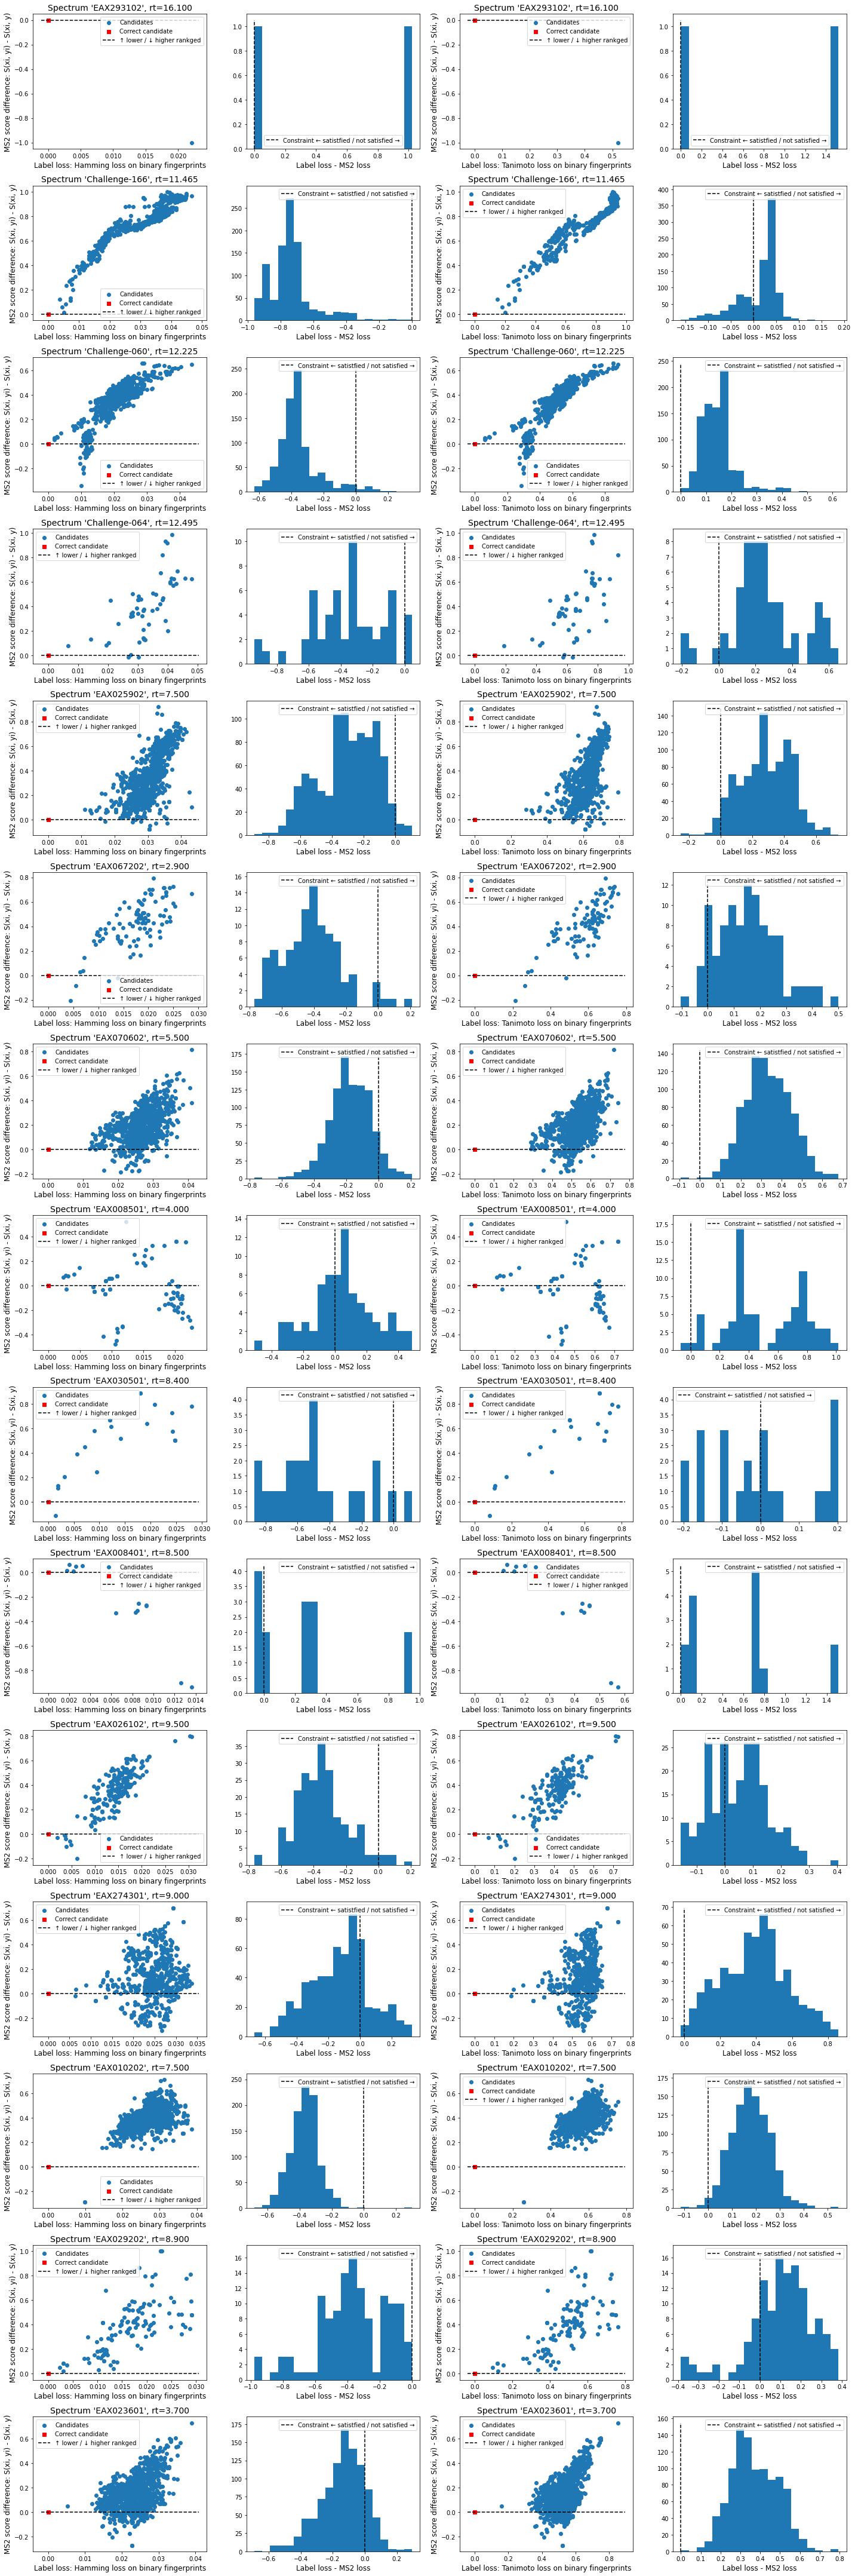

In [9]:
spectra_sub = np.random.RandomState(103).choice(spectra, 15, replace=False)

fig, axrr = plt.subplots(len(spectra_sub), 4, figsize=(20, 4 * len(spectra_sub)))

for r, spectrum in enumerate(spectra_sub):
    # Load MS2 scores and fingerprints
    scores = candidate_db.get_ms2_scores(spectrum, "IOKR__696a17f3", min_score_value=1e-4)
    # scores = candidate_db.get_ms2_scores(spectrum, "MetFrag_2.4.5__8afe4a14")
    fps = candidate_db.get_molecule_features(spectrum, "iokr_fps__positive")

    idx = candidate_db.get_labelspace(spectrum).index(spectrum.metadata["molecule_id"])
    gt_score = scores[idx]
    gt_fp = fps[idx, :]
    
    # Calculate losses
    spec_loss = gt_score - np.array(scores)
    for j, (loss_name, loss_fun) in enumerate([("Hamming", hamming_loss), ("Tanimoto", tanimoto_loss)]):
        label_loss = loss_fun(gt_fp, fps)

        ax = axrr[r, j * 2]
        ax.scatter(label_loss, spec_loss, label="Candidates")
        ax.scatter(0, 0, color="red", marker="s", label="Correct candidate")
        ax.hlines(0, *ax.get_xlim(), color="black", linestyle="--", label="↑ lower / ↓ higher rankged")
        ax.set_xlabel("Label loss: %s loss on binary fingerprints" % loss_name, fontsize=12)
        ax.set_ylabel("MS2 score difference: S(xi, yi) - S(xi, y)", fontsize=12)
        ax.set_title("Spectrum '%s', rt=%.3f" % (spectrum.metadata["spectrum_id"], spectrum.metadata["retention_time"]), fontsize=14)
        ax.legend()

        ax = axrr[r, j * 2 + 1]
        ax.hist(label_loss - spec_loss, bins=20)
        ax.vlines(0, *ax.get_ylim(), color="black", linestyle="--", label="Constraint ← satistfied / not satisfied →")
        ax.set_xlabel("Label loss - MS2 loss", fontsize=12)
        ax.legend()
    
plt.tight_layout()

In [8]:
np.log(1e-4)

-9.210340371976182